In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 07:38:44] [setup] RAM Tracking...
[codecarbon INFO @ 07:38:44] [setup] GPU Tracking...
[codecarbon INFO @ 07:38:44] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:38:44] [setup] CPU Tracking...
[codecarbon WARNING @ 07:38:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 07:38:47] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 07:38:47] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 07:38:47] >>> Tracker's metadata:
[codecarbon INFO @ 07:38:47]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 07:38:47]   Python version: 3.11.3
[codecarbon INFO @ 07:38:47]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 07:38:47]   Available RAM : 256.000 GB
[codecarbon INFO @ 07:38:47]   CPU count: 24
[codecarbon INFO @ 07:38:47]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# For reproducibility. Same as when the model was trained
HASH_NAME = "kmyc4k23vc47"

In [5]:
CONFIG = {"seed": 2022,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [6]:
project_name = "MongoDB"
file_name = f"../csv/clean_{project_name}_balanced.csv"

In [7]:
df = pd.read_csv(file_name)
df

,text_clean,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [9]:
df = df.rename(columns={'text_clean': 'text'})
df = df.dropna()  # This will drop any rows with missing values.
df = df.reset_index(drop=True)
df

,text,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [10]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [11]:
class TD_Model(nn.Module):
    def __init__(self, model_name):
        super(TD_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

<h2> Testing Inference </h2>


In [12]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [13]:
test_df = df

In [14]:
test_df

,text,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [15]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [16]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = TD_Model(CONFIG['model_name'])

In [17]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [18]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [20]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'../01_training/{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 114/114 [00:15<00:00,  7.57it/s]


Fold 1


100%|██████████| 114/114 [00:14<00:00,  8.02it/s]


Fold 2


100%|██████████| 114/114 [00:14<00:00,  8.01it/s]


In [21]:
deberta_predictions


[array([[0.29976806, 0.70023197],
        [0.18184692, 0.8181531 ],
        [0.3117711 , 0.68822896],
        ...,
        [0.18295024, 0.81704974],
        [0.59244776, 0.40755224],
        [0.4555549 , 0.5444451 ]], dtype=float32),
 array([[0.31593144, 0.68406856],
        [0.11890528, 0.88109475],
        [0.32749158, 0.6725084 ],
        ...,
        [0.20453642, 0.79546356],
        [0.65666896, 0.343331  ],
        [0.23671435, 0.7632856 ]], dtype=float32),
 array([[0.2622088 , 0.73779124],
        [0.21383609, 0.7861639 ],
        [0.4860299 , 0.51397014],
        ...,
        [0.26125488, 0.73874515],
        [0.8520073 , 0.14799264],
        [0.24797074, 0.75202924]], dtype=float32)]

In [22]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.29263613, 0.7073639 ],
       [0.17152943, 0.8284705 ],
       [0.3750975 , 0.6249025 ],
       ...,
       [0.21624719, 0.78375286],
       [0.70037466, 0.29962528],
       [0.31341335, 0.6865866 ]], dtype=float32)

In [23]:
len(predictions)

1816

In [24]:
predictions

array([[0.29263613, 0.7073639 ],
       [0.17152943, 0.8284705 ],
       [0.3750975 , 0.6249025 ],
       ...,
       [0.21624719, 0.78375286],
       [0.70037466, 0.29962528],
       [0.31341335, 0.6865866 ]], dtype=float32)

In [25]:
test_df["prediction_0"] = predictions[:, 0] 

In [26]:
test_df["prediction_1"] = predictions[:, 1] 

In [27]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [28]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
0,info ccdashboardauthauthproperties no jwt secr...,0,0.292636,0.707364,1,1,1
1,first logged failure here note that this commi...,1,0.171529,0.828471,1,1,1
2,i perform following tutorial for my knowledgei...,1,0.375098,0.624902,1,1,1
3,description yes it would be a new component of...,1,0.668988,0.331012,0,0,0
4,createuser docs are wrong the name of the user...,1,0.803859,0.196141,0,0,0
...,...,...,...,...,...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0,0.361586,0.638414,1,1,1
1812,we must make sure that there are no more users...,0,0.277443,0.722557,1,1,1
1813,paneltitleissue status as of june issue summar...,1,0.216247,0.783753,1,1,1
1814,the topology coordinator is the repository for...,0,0.700375,0.299625,0,0,0


In [29]:
len(test_df)

1816

In [30]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [31]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [32]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [33]:
test_df["pred"] = test_df["pred"].astype(int)

In [34]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
0,info ccdashboardauthauthproperties no jwt secr...,0,0.292636,0.707364,1,1,1,prediction_1,1
1,first logged failure here note that this commi...,1,0.171529,0.828471,1,1,1,prediction_1,1
2,i perform following tutorial for my knowledgei...,1,0.375098,0.624902,1,1,1,prediction_1,1
3,description yes it would be a new component of...,1,0.668988,0.331012,0,0,0,prediction_0,0
4,createuser docs are wrong the name of the user...,1,0.803859,0.196141,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0,0.361586,0.638414,1,1,1,prediction_1,1
1812,we must make sure that there are no more users...,0,0.277443,0.722557,1,1,1,prediction_1,1
1813,paneltitleissue status as of june issue summar...,1,0.216247,0.783753,1,1,1,prediction_1,1
1814,the topology coordinator is the repository for...,0,0.700375,0.299625,0,0,0,prediction_0,0


In [35]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[637 271]
 [381 527]]


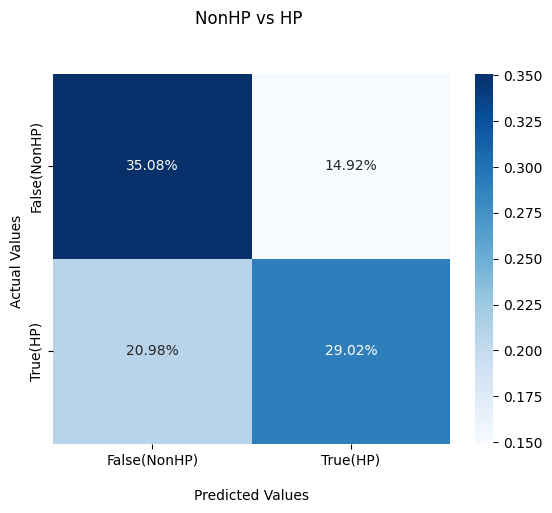

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [37]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       908
           1       0.66      0.58      0.62       908

    accuracy                           0.64      1816
   macro avg       0.64      0.64      0.64      1816
weighted avg       0.64      0.64      0.64      1816



In [40]:
test_df[["text","label","pred"]].to_csv(f"csv/{project_name}_Test_inference.csv")

In [41]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
0,info ccdashboardauthauthproperties no jwt secr...,0,0.292636,0.707364,1,1,1,prediction_1,1
1,first logged failure here note that this commi...,1,0.171529,0.828471,1,1,1,prediction_1,1
2,i perform following tutorial for my knowledgei...,1,0.375098,0.624902,1,1,1,prediction_1,1
3,description yes it would be a new component of...,1,0.668988,0.331012,0,0,0,prediction_0,0
4,createuser docs are wrong the name of the user...,1,0.803859,0.196141,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0,0.361586,0.638414,1,1,1,prediction_1,1
1812,we must make sure that there are no more users...,0,0.277443,0.722557,1,1,1,prediction_1,1
1813,paneltitleissue status as of june issue summar...,1,0.216247,0.783753,1,1,1,prediction_1,1
1814,the topology coordinator is the repository for...,0,0.700375,0.299625,0,0,0,prediction_0,0


In [ ]:
tracker.stop()